In [68]:
import numpy as np
import cv2
from debayer.superpixel import debayer_superpixel
from astropy.io import fits
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project
import matplotlib.pyplot as plt

## Cone search given object sky-coord

In [69]:
def cone_search_stardata(skymap: SkyMap, center: SkyCoord, fov_deg: float):
  stars = []
  for star in skymap.coneSearch(center, fov_deg):
    if 'mag' in star and star['mag']:# and star['mag'] < 11:
      print(star)
      s_coord = SkyCoord(star['icrs']['deg']['ra'] * u.degree, star['icrs']['deg']['dec'] * u.degree, frame=ICRS)
      x, y = project(s_coord.ra.degree, s_coord.dec.degree, center.ra.degree, center.dec.degree, 0)
      stars.append({"id": star["_id"], "cluster_cx": x, "cluster_cy": y, "ra": s_coord.ra.degree, "dec": s_coord.dec.degree})
  df_ref = pd.DataFrame(stars)
  return df_ref

# M101
# center = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS)
center = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS)
with SkyMap() as sm:
  df_ref = cone_search_stardata(sm, center, fov_deg=5.0)

{'_id': '*86UMa', 'id': '* 86 UMa', 'typ': 'Star', 'icrs': {'hmsdms': {'ra': '13h53m51.0140209224s', 'dec': '+53d43m43.235077944s'}, 'deg': {'ra': 208.46255842051, 'dec': 53.728676410540004}, 'location': {'type': 'Point', 'coordinates': [28.462558420509993, 53.728676410540004]}}, 'gal': {'ra': 103.7614298362323, 'dec': 61.0151014282604}, 'pm': [-28.717, -6.396], 'mag': 5.695, 'spec': 'A0V', 'size': None, 'distance': 174749.01900459232}
{'_id': 'HD125632', 'id': 'HD 125632', 'typ': 'Double or Multiple Star', 'icrs': {'hmsdms': {'ra': '14h18m55.9164174192s', 'dec': '+54d51m49.614864948s'}, 'deg': {'ra': 214.73298507258, 'dec': 54.86378190693}, 'location': {'type': 'Point', 'coordinates': [34.73298507257999, 54.86378190693]}}, 'gal': {'ra': 99.0506281984822, 'dec': 58.019742790714}, 'pm': [-19.952, -5.141], 'mag': 6.48, 'spec': 'A5Vn', 'size': None, 'distance': 251599.96014137953, 'HD': '125632'}
{'_id': 'HD125019', 'id': 'HD 125019', 'typ': 'Star', 'icrs': {'hmsdms': {'ra': '14h15m16.995

In [70]:
df_ref

,id,cluster_cx,cluster_cy,ra,dec
0,*86UMa,-0.026176,-0.008081,208.462558,53.728676
1,HD125632,0.037486,0.012252,214.732985,54.863782
2,HD125019,0.029951,-0.028765,213.820816,52.535924
3,HD125469,0.034161,0.021895,214.449591,55.425361
4,HD125260,0.031072,0.019533,214.127187,55.298356
...,...,...,...,...,...
213,TYC3855-157-1,0.020872,0.032847,213.142079,56.082756
214,TYC3855-864-1,0.005157,0.025859,211.522766,55.699250
215,GSC03852-01084,0.023143,0.004081,213.278650,54.431009
216,BD+551642,-0.027513,0.001496,208.297724,54.274140


## Plot of stars in the neighborhood

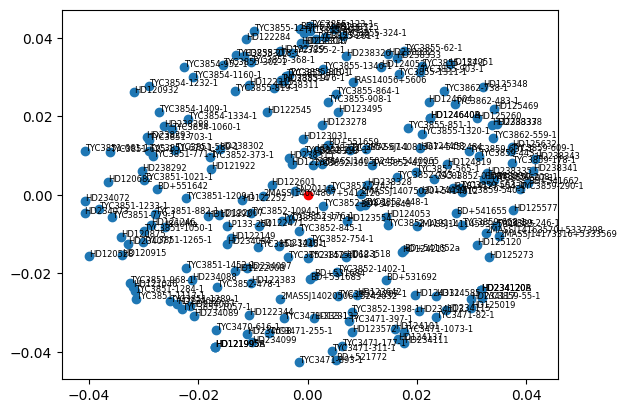

In [71]:
plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy)
for i in range(len(df_ref)):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')

plt.show()

In [72]:
df_ref.head()

,id,cluster_cx,cluster_cy,ra,dec
0,*86UMa,-0.026176,-0.008081,208.462558,53.728676
1,HD125632,0.037486,0.012252,214.732985,54.863782
2,HD125019,0.029951,-0.028765,213.820816,52.535924
3,HD125469,0.034161,0.021895,214.449591,55.425361
4,HD125260,0.031072,0.019533,214.127187,55.298356


## Read image and run star matching

In [73]:
# fname = r"D:\Astro\20230528-M101-Supernova\20230601\M101\Light\Light_02780_180.0sec_300gain_0.0C.fit"
fname = r"D:\Astro\20230319-M81M82_M101_M13\Light-M101-300sec\Light_ASIImg_300sec_Bin1_-9.4C_gain200_2023-03-20_023749_frame0026.fit"
with fits.open(fname) as f:
    ph = f[0]
    img = ph.data
    img = np.expand_dims(img, axis=2)
    img16 = debayer_superpixel(img)

assert(img16.dtype == np.uint16)
assert(len(img16.shape) == 3)
assert(img16.shape[2] == 3)
img16 = cv2.cvtColor(img16, cv2.COLOR_RGB2GRAY)
img8 = ((img16 / np.iinfo(np.uint16).max) *np.iinfo(np.uint8).max).astype(np.uint8)
numStars = 20
star_img, df_tgt = StarFinder().find_stars(img8=np.squeeze(img8), img16=np.squeeze(img16), topk=numStars)

# votes, vVotingPairs = StarMatcher().matchStars(df_ref, df_tgt, return_merged=False)


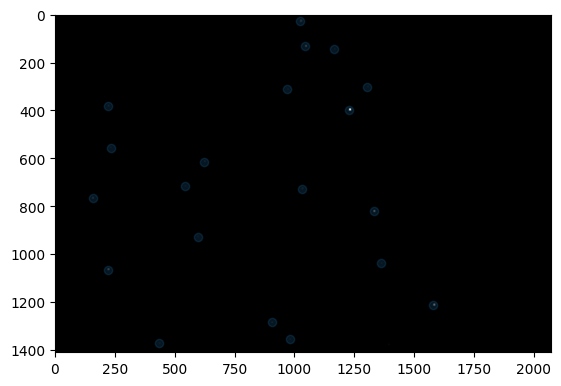

In [74]:
plt.imshow(star_img, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2)

In [75]:
m = StarMatcher()
tri_ref = m._getVertexSortedTriangles(df_ref)
tri_tgt = m._getVertexSortedTriangles(df_tgt)

In [76]:

from itertools import product

vertex_sorted = True
down_votes = True
absolute_similar = True
vote_with_conf = True

votes_per_tol = {}

for TRIANGLETOLERANCE in [1e-3]: #, 2e-4, 1e-4, 1e-5, 1e-6]:
    votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.float32)

    for tgt in tri_tgt.itertuples():
        if absolute_similar:
            similar_triangles = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2) &
                (tri_ref.fY >= tgt.fY - TRIANGLETOLERANCE/2) &
                (tri_ref.fY <= tgt.fY + TRIANGLETOLERANCE/2)
            ]
        else:
            ref_matches = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2)]
            similar_triangles = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]

        for ref in similar_triangles.itertuples():
            if vote_with_conf:
                err = ((ref.fX-tgt.fX)**2 + (ref.fY-tgt.fY)**2)
                upvote = 1/(np.exp(err*100))
                downvote = upvote / 4
            else:
                upvote = 1
                downvote = 1/4

            if vertex_sorted:
                # expect matched ABC vertices
                votes[ref.A, tgt.A] += upvote
                votes[ref.B, tgt.B] += upvote
                votes[ref.C, tgt.C] += upvote

                if down_votes:
                    votes[ref.A, tgt.B] -= downvote
                    votes[ref.A, tgt.C] -= downvote

                    votes[ref.B, tgt.A] -= downvote
                    votes[ref.B, tgt.C] -= downvote
                    
                    votes[ref.C, tgt.A] -= downvote
                    votes[ref.C, tgt.B] -= downvote
            else:
                # expect unordered star indices s1, s2, s3
                for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
                    votes[int(a), b] += upvote

    votes_per_tol[TRIANGLETOLERANCE] = votes
    print(f"TRIANGLETOLERANCE: {TRIANGLETOLERANCE}")
    print(f"Total triangle comparisons: {len(tri_ref) * len(tri_tgt)}")
    print(f"Total votes: {np.sum(votes)}, hit-ratio: {np.sum(votes) / (len(tri_ref) * len(tri_tgt))}")

TRIANGLETOLERANCE: 0.001
Total triangle comparisons: 1941438240
Total votes: 20599.166015625, hit-ratio: 1.0610260780494877e-05


In [77]:
votes=votes_per_tol[1e-3]

In [78]:
with open('votes.csv', 'wt') as f:  
  arr = votes.flatten()
  for i in range(arr.shape[0]):
    f.write(f"{arr[i]}\n")


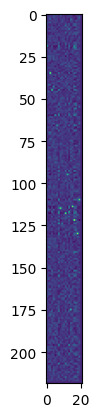

In [79]:
plt.imshow(votes)

(array([4.780e+02, 3.006e+03, 9.580e+02, 1.220e+02, 2.000e+01, 4.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 1.000e+00]),
 array([-8.99989033, -0.9250043 ,  7.14988184, 15.22476768, 23.29965401,
        31.37454033, 39.44942474, 47.52431107, 55.59919739, 63.67408371,
        71.74897003]),
 <BarContainer object of 10 artists>)

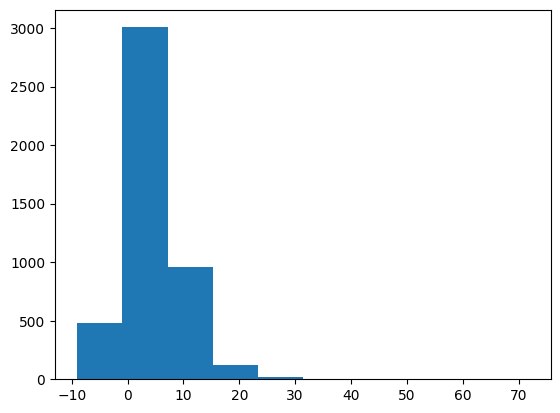

In [80]:
plt.hist(votes.flatten())

In [81]:
# Produce sorted list of star pairs with highest votes
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [82]:
cutoff = votes.max() / 2
# print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

matches = []
for vp in topVotePairs:
    s1, s2 = vp
    # if s1 == 0 or s2 == 0: # WHY ?
    #     continue
    if np.argmax(votes[:, s2]) == s1 and np.argmax(votes[s1, :]) == s2:
        matches.append((s1, s2))

df_tgt['starno'] = None
df_tgt['votes'] = None
for m1, m2 in matches:
    df_tgt.loc[m2, 'starno'] = m1
    df_tgt.loc[m2, 'votes'] = votes[m1, m2]

In [83]:
d = []
# n = []
for i in range(len(df_tgt)):
    m = votes[:,i]
    ave = (m.sum() - m.max())/(len(m)-1)
    d.append((m.max()-ave)/ave)
    # n.append(len(np.argwhere(m > 2 * ave)))
print(d)
# print(n)
# plt.plot(m)
# plt.plot(np.arange(0, len(m)), np.full(len(m), ave))


[10.528306040500507, 3.64074289864699, 12.29786270399914, 10.434571446040124, 4.828892374720441, 6.84847339172598, 7.0884625957972345, 4.8495494710473706, 15.166028926697779, 3.603290829276071, 2.8869527035202873, 11.335781051012738, 9.4625459201727, 7.601623845336883, 7.8856137678911695, 12.747807888691373, 11.950958816555897, 3.1329321307441647, 13.274530636900536, 11.93474680720123]


## Matched stars

In [84]:
# display(df_tgt[~df_tgt.starno.isnull()])
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes
0,171,1229.491228,397.777778,13.000977,13.000977,14.569629,14.323108,"[1215, 383, 1244, 412]",51589,818,29.745137,29.700816,19,49.999245
1,159,1025.257862,27.314465,11.000977,13.000977,14.204040,12.066062,"[1013, 13, 1038, 42]",3882,97,56.807613,50.891973,None,None
2,136,1580.705882,1212.779412,11.000977,11.000977,12.420077,12.334760,"[1568, 1200, 1593, 1225]",157349,2519,25.800025,25.845320,35,63.499302
3,112,1330.875000,822.107143,10.000977,10.000977,10.997354,11.459947,"[1319, 811, 1342, 834]",107041,1732,23.500223,23.804930,45,53.749432
4,104,222.509615,1064.903846,9.000977,10.000977,11.363386,10.284586,"[212, 1053, 233, 1076]",137844,2152,23.441398,21.519018,None,None
5,95,1045.715789,132.694737,9.000977,9.000977,10.501856,10.696529,"[1035, 122, 1056, 143]",17355,293,22.203937,22.564699,None,None
6,95,157.631579,766.463158,9.000977,9.000977,10.274423,10.490433,"[147, 756, 168, 777]",99495,1565,22.139461,22.595639,None,None
7,78,1031.410256,726.602564,7.000977,9.000977,10.726575,8.380279,"[1023, 716, 1040, 737]",94534,1527,46.216524,40.305218,None,None
8,63,1304.555556,301.555556,7.000977,7.000977,8.483419,8.049427,"[1296, 293, 1313, 310]",39176,626,17.336642,17.090585,115,58.749226
9,63,1361.555556,1038.555556,7.000977,7.000977,8.824015,8.050543,"[1353, 1030, 1370, 1047]",135020,2123,17.769586,17.199474,None,None


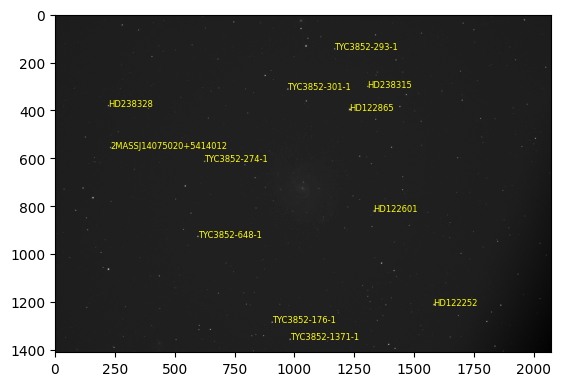

In [85]:
plt.imshow(img8, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='yellow')

## Calculate transformation matrix
From known star mapping to image, compute affine transformation to map database projection to image

In [157]:
img_stars = df_tgt[~df_tgt.starno.isnull()][['starno','cluster_cx', 'cluster_cy', 'votes']]
img_ref_stars = df_ref[['id','cluster_cx', 'cluster_cy', 'ra', 'dec']].join(img_stars.set_index('starno'), rsuffix='r', how='right')
display(img_ref_stars)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
19,HD122865,-0.002932,0.007816,210.708008,54.666101,1229.491228,397.777778,49.999245
35,HD122252,-0.012055,-0.001399,209.819503,54.132680,1580.705882,1212.779412,63.499302
45,HD122601,-0.006576,0.002585,210.351711,54.364956,1330.875000,822.107143,53.749432
115,HD238315,-0.003434,0.009523,210.657476,54.763749,1304.555556,301.555556,58.749226
118,TYC3852-301-1,0.001047,0.007591,211.102128,54.653461,971.000000,312.500000,60.249138
95,HD238328,0.010846,0.002653,212.065167,54.365932,223.000000,381.500000,42.749344
117,TYC3852-648-1,0.002871,-0.002787,211.278747,54.058560,596.000000,927.500000,39.249203
175,TYC3852-293-1,-0.000713,0.010905,210.927480,54.843380,1166.000000,145.000000,43.999371
114,2MASSJ14075020+5414012,0.009800,0.000330,211.959171,54.233677,232.000000,556.000000,57.749302


In [158]:
matched_star_triple = img_ref_stars.sort_values('votes', ascending=False)[:3]
display(matched_star_triple)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
122,TYC3852-274-1,0.004157,0.001636,211.406708,54.311622,624.000000,614.000000,71.74897
35,HD122252,-0.012055,-0.001399,209.819503,54.132680,1580.705882,1212.779412,63.499302
130,TYC3852-176-1,-0.003258,-0.006004,210.681806,53.874197,905.000000,1286.000000,62.499134


In [88]:
src = np.array([(row.cluster_cx, row.cluster_cy) for _, row in matched_star_triple.iterrows()], dtype=np.float32)
dst = np.array([(row.cluster_cxr, row.cluster_cyr) for _, row in matched_star_triple.iterrows()], dtype=np.float32)

In [89]:
import cv2
tx = cv2.getAffineTransform(src, dst)
print(tx)

[[-63700.7706523   25046.96698552    847.81530027]
 [-25013.42569095 -63688.27200612    822.14520922]]


In [90]:
pts = np.array([[(r.cluster_cx, r.cluster_cy) for _,r in df_ref.iterrows()]], dtype=np.float32)
tx_pts = cv2.transform(pts, tx)
print(pts.shape, tx_pts.shape)
display(np.hstack([pts[0], tx_pts[0]])[0:5])

(1, 218, 2) (1, 218, 2)


array([[-2.6176000e-02, -8.0805570e-03,  2.3128533e+03,  1.9915334e+03],
       [ 3.7485849e-02,  1.2251842e-02, -1.2331906e+03, -8.9580292e+02],
       [ 2.9950602e-02, -2.8765356e-02, -1.7805460e+03,  1.9049939e+03],
       [ 3.4160659e-02,  2.1895375e-02, -7.7983228e+02, -1.4268083e+03],
       [ 3.1072250e-02,  1.9532695e-02, -6.4227612e+02, -1.1990818e+03]],
      dtype=float32)

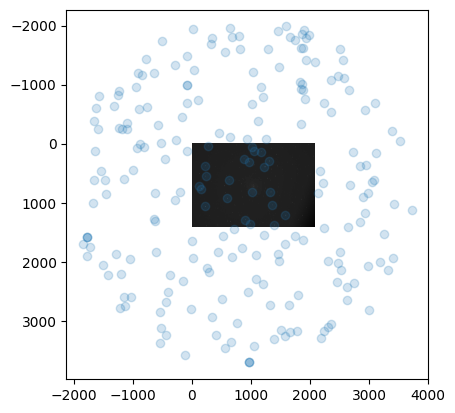

In [94]:
# pts = tx * pts
plt.imshow(img8, cmap='gray')
plt.scatter(tx_pts[0, :, 0], tx_pts[0, :, 1], alpha=0.2)

## Map pixel coordinated to RA,DEC
Use linear regression to fit a function to map pixel coordinates to RA,DEC.
Useful to find RA, DEC of image center.

In [184]:
from sklearn.linear_model import LinearRegression
X = img_ref_stars[['cluster_cxr', 'cluster_cyr']]
y = img_ref_stars[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict([[img8.shape[1]//2, img8.shape[0]//2]])[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80875816, 54.36594231)>
Separation from target: 11.058621220986753


c:\Users\anand\anaconda3\envs\astro\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
